PROJETO TRANSFER LEARNING PARA DIO

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import os

# Google Drive
print("Montando Google Drive...")
drive.mount('/content/drive')
print("Google Drive montado.")

base_dir = '/content/drive/MyDrive/projeto-transferlearning-dio/dataset'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

CLASSES = ['loide', 'debi']

# Parâmetros do modelo
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

# Verificando se os diretórios existem
print(f"Verificando diretórios:")
print(f"Diretório base: {base_dir} - {'Existe' if os.path.exists(base_dir) else 'NÃO EXISTE!'}")
print(f"Diretório de treino: {train_dir} - {'Existe' if os.path.exists(train_dir) else 'NÃO EXISTE!'}")
print(f"Diretório de validação: {validation_dir} - {'Existe' if os.path.exists(validation_dir) else 'NÃO EXISTE!'}")

if not os.path.exists(train_dir) or not os.path.exists(validation_dir):
    print("\nERRO: Um ou mais diretórios não foram encontrados. Por favor, verifique o 'base_dir' e a estrutura das pastas no seu Google Drive.")

Montando Google Drive...
Mounted at /content/drive
Google Drive montado.
Verificando diretórios:
Diretório base: /content/drive/MyDrive/projeto-transferlearning-dio/dataset - Existe
Diretório de treino: /content/drive/MyDrive/projeto-transferlearning-dio/dataset/train - Existe
Diretório de validação: /content/drive/MyDrive/projeto-transferlearning-dio/dataset/validation - Existe


In [2]:
print("\nConfigurando geradores de dados...")

# Gerador de treino com Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Gerador de validação
validation_datagen = ImageDataGenerator(rescale=1./255.)

# Carregar imagens do diretório de treino
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASSES,
    shuffle=True
)

# Carregar imagens do diretório de validação
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASSES,
    shuffle=False
)

print(f"Índices das classes: {train_generator.class_indices}")



Configurando geradores de dados...
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Índices das classes: {'loide': 0, 'debi': 1}


In [3]:
print("\nConstruindo o modelo MobileNetV2 com Transfer Learning...")

# Carregar o modelo base MobileNetV2
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Modelo base
base_model.trainable = False

# Camadas de classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Criando modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("Modelo construído e compilado.")


Construindo o modelo MobileNetV2 com Transfer Learning...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Modelo construído e compilado.


In [4]:
print("\nIniciando o treinamento do modelo...")

# Calcular o número de passos por época
steps_per_epoch = train_generator.n // BATCH_SIZE
validation_steps = validation_generator.n // BATCH_SIZE

# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

print("\nTreinamento concluído.")


Iniciando o treinamento do modelo...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.3750 - loss: 0.9445 - val_accuracy: 0.4000 - val_loss: 0.7999
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3750 - loss: 0.8024 - val_accuracy: 0.3000 - val_loss: 0.7822
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3750 - loss: 0.8305 - val_accuracy: 0.3000 - val_loss: 0.7702
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4375 - loss: 0.9213 - val_accuracy: 0.3000 - val_loss: 0.7609
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3750 - loss: 1.0197 - val_accuracy: 0.4000 - val_loss: 0.7528
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.7111 - val_accuracy: 0.4000 - val_loss: 0.7476
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3750 - loss: 0.7593 - val_accuracy: 0.5000 - val_loss: 0.7438
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5625 - loss: 0.6634 - val_accuracy: 0.5000 - val_loss: 0.7400
Epoch 9/15
1/1


Plotando gráficos de acurácia e perda...


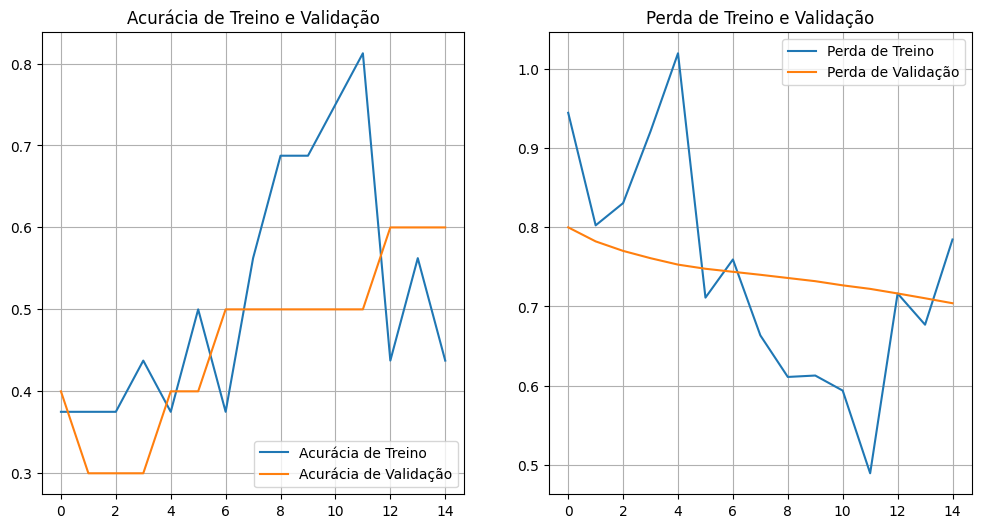

Gráficos gerados.


In [5]:
print("\nPlotando gráficos de acurácia e perda...")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.grid(True)

plt.show()
print("Gráficos gerados.")


Preparando para testar com uma nova imagem...


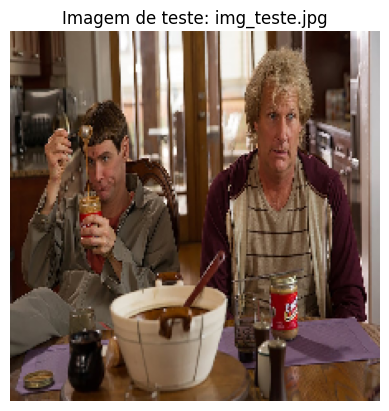

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Valor de probabilidade previsto: 0.2337
A imagem é provavelmente: LOIDE


In [6]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

print("\nPreparando para testar com uma nova imagem...")

imagem_para_teste = '/content/drive/MyDrive/projeto-transferlearning-dio/img_teste.jpg'


# Carregar e redimensionar a imagem
img = image.load_img(imagem_para_teste, target_size=IMG_SIZE)
plt.imshow(img)
plt.axis('off')
plt.title(f"Imagem de teste: {os.path.basename(imagem_para_teste)}")
plt.show()

# Converter para array NumPy
img_array = image.img_to_array(img)

img_array_expanded = np.expand_dims(img_array, axis=0)

img_preprocessed = img_array_expanded / 255.

prediction = model.predict(img_preprocessed)

class_indices = train_generator.class_indices
inverse_class_indices = {v: k for k, v in class_indices.items()}

predicted_proba = prediction[0][0]

print(f"\nValor de probabilidade previsto: {predicted_proba:.4f}")

if predicted_proba > 0.5:
    predicted_class_index = 1
else:
    predicted_class_index = 0

predicted_class_name = inverse_class_indices[predicted_class_index]

print(f"A imagem é provavelmente: {predicted_class_name.upper()}")

if 0.4 < predicted_proba < 0.6:
    print(" (Nota: A confiança do modelo está um pouco baixa para esta previsão.)")